In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.applications import MobileNetV3Large

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


2022-03-13 19:21:53.526655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-13 19:21:53.526685: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/train"
test_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/test"



In [3]:
# No preprocess function is passed because mobileNetV3 has it builtIn 

train_batches  = ImageDataGenerator().flow_from_directory(train_path,target_size=[64,64],batch_size=30)
test_batches  = ImageDataGenerator().flow_from_directory(test_path,target_size=[64,64],batch_size=20)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [4]:
base_model = MobileNetV3Large(weights='imagenet',include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=preds)

2022-03-13 19:22:15.924042: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-13 19:22:15.924088: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-13 19:22:15.924119: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-03-13 19:22:15.924425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

# Freezing the non training Layers

In [6]:
for layers in model.layers[:-5]:
     layers.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

# Compiling and Fitting the Model

In [7]:
epochs = 20 # final

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

history = model.fit(train_batches,validation_data=test_batches,epochs=epochs)


Epoch 1/20
80/80 [==============================] - 13s 106ms/step - loss: 0.6492 - accuracy: 0.6712 - val_loss: 0.5547 - val_accuracy: 0.7700
Epoch 2/20
80/80 [==============================] - 7s 89ms/step - loss: 0.4657 - accuracy: 0.8275 - val_loss: 0.3972 - val_accuracy: 0.8333
Epoch 3/20
80/80 [==============================] - 7s 89ms/step - loss: 0.3483 - accuracy: 0.8775 - val_loss: 0.3181 - val_accuracy: 0.8950
Epoch 4/20
80/80 [==============================] - 7s 89ms/step - loss: 0.2799 - accuracy: 0.8996 - val_loss: 0.2686 - val_accuracy: 0.9100
Epoch 5/20
80/80 [==============================] - 7s 89ms/step - loss: 0.2328 - accuracy: 0.9233 - val_loss: 0.2409 - val_accuracy: 0.9067
Epoch 6/20
80/80 [==============================] - 7s 92ms/step - loss: 0.1972 - accuracy: 0.9392 - val_loss: 0.2152 - val_accuracy: 0.9067
Epoch 7/20
80/80 [==============================] - 7s 90ms/step - loss: 0.1682 - accuracy: 0.9517 - val_loss: 0.2014 - val_accuracy: 0.9200
Epoch 8/20


In [8]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

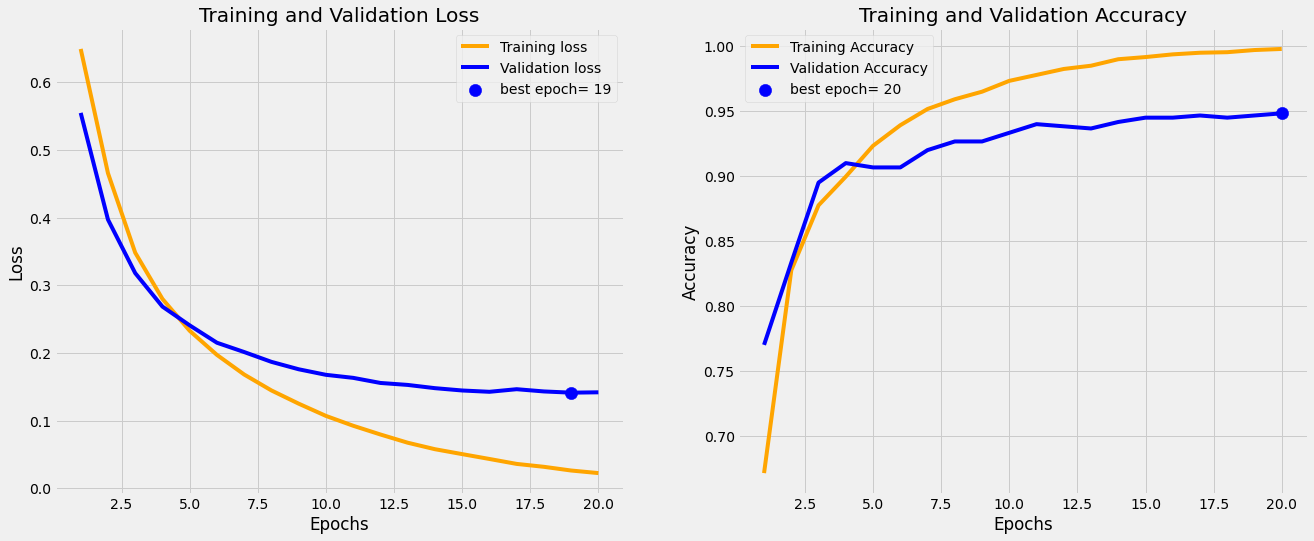

In [9]:
tr_plot(history,0)
plt.savefig('mobileNet_V3_LARGE_epoch2_20_batch_size_30_final.png')


In [10]:
model.save('BrainTumor_MobileNet_V3LARGE_epochs_20_final.h5')